# Some methods of WIS Kepler pipeline applied to some TESS data
16 Nov 2023, Oryna Ivashtenko

In [1]:
import os
import numpy as np
import copy
from scipy.stats import chi2, norm, mode
from astropy.table import QTable
from astropy.io import fits
from astroquery.mast import Observations

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
# plt.rcParams['figure.figsize'] = [5, 3]
def_cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

import tess_utils as ut

# Before starting:

This notebook requires you to specify which data you want to process.
There will be a tentative list of TGLC targets is provided for an example. In order to investigate other targets, specify the object ID and the provenance source.

Also, you need to pot here your template. Here is a tentative set of templates. Run the following cell to load it


In [2]:
with open('templates_trial.txt', 'r') as fil:
    lines = fil.readlines()
templates_trial = [np.array(line.split()).astype(float) for line in lines]

Text(0, 0.5, 'Template normalized')

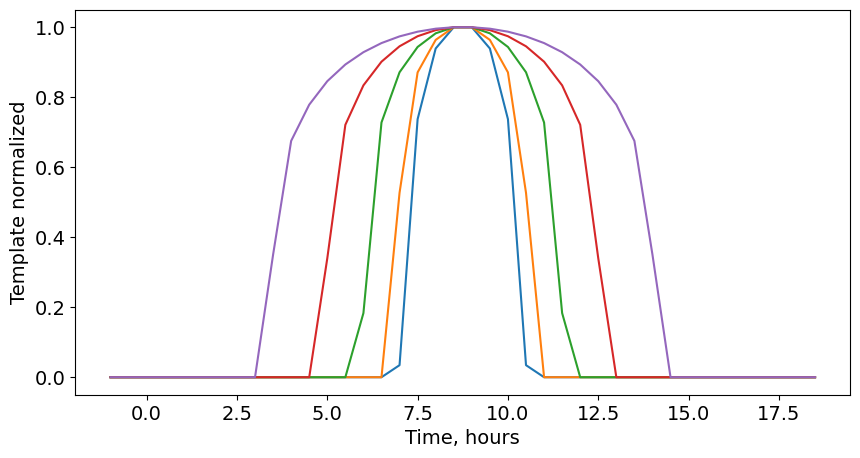

In [3]:
plt.figure(figsize=(10,5))
for i in range(len(templates_trial)):
    plt.plot(24 * 0.0208335 * (np.arange(0,len(templates_trial[0])) - (len(templates_trial)-1)/2),
             templates_trial[i])
plt.xlabel('Time, hours')
plt.ylabel('Template normalized')

# Query and download the data for one target

You specify `tessid` and other parameters. You can uncomment the corresponding lines to use the needed parameter.

- `tessid` - Tess target ID. Only digitals, without zeros in the beginning
- `obs_collection` - Data collection, either `'TESS'` or `'HLSP'`
- `provenance_name` - Team which produced the light curves:
  - 'TGLC' - Tess-Gaia light curves, only certain stars so far
  - 'TESS-SPOC' - TESS Light Curves From Full Frame Images, mag>13.5
  - 'GSFC-ELEANOR-LITE' - FFI-Based Light Curves from the GSFC Team, mag<16
  - 'QLP' - TESS Lightcurves From The MIT Quick-Look Pipeline, mag<13.5
- `sequence_number` - sector number
- `s_ra` - right ascention if you want to make a cone search. Then no need to specify the `tessid`
- `s_dec` - declination if you want to make a cone search. Then no need to specify the `tessid`

Put your parameters and run the cell. Then run the next cell to download the data. A folder will be created in the current working directory, in which the light curve files will be saved.

In [19]:
tessid = '150274888' # this is an example
data_dir = os.path.abspath('.')

obs_table = Observations.query_criteria(target_name=tessid,
                                        project='TESS',
                                        dataproduct_type='timeseries',
                                        #obs_collection='TESS', 
                                        # obs_collection='HLSP',
                                        provenance_name='TGLC',
                                        #provenance_name='TESS-SPOC', # TESS Light Curves From Full Frame Images, mag>13.5
                                        #provenance_name='GSFC-ELEANOR-LITE', # FFI-Based Light Curves from the GSFC Team mag>16
                                        #provenance_name='QLP', # TESS Lightcurves From The MIT Quick-Look Pipeline mag<13.5
                                        #sequence_number='9',
                                        #s_ra=[110,111],
                                        #s_dec=[-75,74]
                                       )
if len(obs_table)==0:
    print('No data for these parameters found!')

# obs_table['target_name'], which is the TIC ID
obs_table                                           

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,sequence_number,obs_id,s_ra,s_dec,proposal_id,proposal_pi,dataproduct_type,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_type,dataRights,mtFlag,obsid,objID
str7,str4,str4,str10,str4,str4,str7,str9,str1,int64,str73,float64,float64,str3,str17,str10,int64,float64,float64,float64,float64,float64,str1,float64,str1,str6,bool,str9,str9
science,HLSP,TGLC,Photometer,TESS,TESS,Optical,150274888,--,1,hlsp_tglc_tess_ffi_gaiaid-5478370320946400768-s0001-cam4-ccd4_tess_v1_llc,95.01140202552752,-62.31752252576477,N/A,Timothy D. Brandt,timeseries,4,58324.82273773066,58352.65635941506,1800.0,600.0,1000.0,--,59945.0,--,PUBLIC,False,110037841,204032135
science,HLSP,TGLC,Photometer,TESS,TESS,Optical,150274888,--,2,hlsp_tglc_tess_ffi_gaiaid-5478370320946400768-s0002-cam4-ccd4_tess_v1_llc,95.01140202552752,-62.31752252576477,N/A,Timothy D. Brandt,timeseries,4,58353.61439562715,58380.98968387775,1800.0,600.0,1000.0,--,59982.82312493,--,PUBLIC,False,114694742,212483974
science,HLSP,TGLC,Photometer,TESS,TESS,Optical,150274888,--,3,hlsp_tglc_tess_ffi_gaiaid-5478370320946400768-s0003-cam4-ccd4_tess_v1_llc,95.01140202552752,-62.31752252576477,N/A,Timothy D. Brandt,timeseries,4,58381.55188484835,58408.86467416203,1800.0,600.0,1000.0,--,60027.80271977,--,PUBLIC,False,120698268,224147636
science,HLSP,TGLC,Photometer,TESS,TESS,Optical,150274888,--,4,hlsp_tglc_tess_ffi_gaiaid-5478370320946400768-s0004-cam4-ccd1_tess_v1_llc,95.01140202552752,-62.31752252576477,N/A,Timothy D. Brandt,timeseries,4,58410.4281093477,58436.32421132698,1800.0,600.0,1000.0,--,60083.72422442,--,PUBLIC,False,137935661,252486859
science,HLSP,TGLC,Photometer,TESS,TESS,Optical,150274888,--,5,hlsp_tglc_tess_ffi_gaiaid-5478370320946400768-s0005-cam4-ccd1_tess_v1_llc,95.01140202552752,-62.31752252576477,N/A,Timothy D. Brandt,timeseries,4,58437.49059086144,58463.76169767788,1800.0,600.0,1000.0,--,60145.34385416,--,PUBLIC,False,153537417,276216943
science,HLSP,TGLC,Photometer,TESS,TESS,Optical,150274888,--,6,hlsp_tglc_tess_ffi_gaiaid-5478370320946400768-s0006-cam4-ccd1_tess_v1_llc,95.01140202552752,-62.31752252576477,N/A,Timothy D. Brandt,timeseries,4,58467.78229336195,58489.53251491104,1800.0,600.0,1000.0,--,60178.61090271,--,PUBLIC,False,170855331,299552949


In [ ]:
data_products = Observations.get_product_list(obs_table)
product_uris = [data_products[i]["dataURI"] for i in range(len(data_products)) 
            if ('_lc.fits' in data_products[i]["dataURI"] or '_llc.fits' in data_products[i]["dataURI"])]
if len(product_uris)==0:
    print('No lightcurves for these parameters found!')
else:
    if tessid not in os.listdir(data_dir):
        os.mkdir(os.path.join(data_dir, tessid))
    for i in range(len(product_uris)):
        local_path = os.path.join(data_dir, tessid, os.path.basename(product_uris[i]))
        result = Observations.download_file(product_uris[i], local_path=local_path) 

# Downloading multiple light curves (If you only need one, skip this)

If you want to download many light curves, you need to provide a list of target IDs. An example is given below. Also, you can specify all the other parameters as described above. Put them in the `query_criteria` field.

In [ ]:
tess_ids = ['150274888',
 '358458856',
 '271722001',
 '382030826',
 '350480719',
 '167808399',
 '374911226',
 '382302559',
 '142109405',
 '33834042',
 '350446239',
 '260131998',
 '.DS_Store',
 '25078134',
 '279159822',
 '32092692',
 '260191033',
 '260005082',
 '262496734',
 '382198723',
 '382042992',
 '350478095',
 '33836621',
 '278023094',
 '279157904',
 '33732068',
 '38515312',
 '299802505',
 '374859744',
 '220461282',
 '382033278',
 '55499864',
 '55741052',
 '293218986',
 '350478546',
 '29780682',
 '370037569',
 '358403155',
 '55272182',
 '25132372',
 '350930333',
 '33714662',
 '350824648',
 '350710006',
 '348840631',
 '382259005',
 '220480647',
 '381974261',
 '382099775',
 '382302614',
 '25117318',
 '260474881',
 '55295095',
 '149472955',
 '150190335',
 '140636323',
 '270427193',
 '382157308',
 '261059281',
 '382188153',
 '55399354',
 '38696281',
 '300012030',
 '55603644',
 '38813309',
 '141280920',
 '350335590',
 '271595267',
 '220398365',
 '350344552']

In [ ]:
# Search for normal TESS light curves
data_dir = os.path.abspath('.')

for tessid in tess_ids:
    try:
        obs_table = Observations.query_criteria(target_name=tessid,  # '389023759'
                                                provenance_name='TGLC')
        if len(obs_table)>0:
            data_products = Observations.get_product_list(obs_table)
            if tessid not in os.listdir(data_dir):
                os.mkdir(os.path.join(data_dir, tessid))
            for i in range(len(data_products)):
                local_path = os.path.join(data_dir, tessid, os.path.basename(data_products[i]["dataURI"]))
                product = data_products[i]["dataURI"] # download the first light curve if multiple lcs are returned
                if ('_lc.fits' in product or '_llc.fits' in product):
                    result = Observations.download_file(product, local_path=local_path) # check obs_table['target_name'], which is the TIC ID
    except:
        pass

# Pipeline proxy (just run this cell to activate the class)

In [188]:
class TESSLightCurve(object):
    def __init__(self, tess_id, data_dir):  
        self.tess_id = tess_id
        self.get_data(data_dir=data_dir)
        self.dt = np.mean([ut.get_dt(tim) for tim in self.times_orig])
        self.means = []
        for s in range(len(self.times_orig)):
            self.means.append(np.nanmedian(self.fluxes_orig[s][self.masks_orig[s]]))
    
    def process_template_get_snr(self, template, nsig_outliers=5, detrending_length=64, psd_window=32, max_hole=3):
        """
        Template should be with baseline zero and deviation in the positive direction, centered at the center.
        """
        self.fill_exposures()
        self.mask_outliers(n_sigma=nsig_outliers)
        self.clean_masks(max_hole=max_hole)
        self.deternd_low_freq(det_len=detrending_length)
        self.measure_psd(nperseg=psd_window)
        self.pad_with_zeros()
        self.whiten_fluxes()
        self.whiten_template(template=template)
        self.matched_filtering()

    def get_data(self, data_dir):
        tessid_fold = os.path.join(data_dir, self.tess_id)
        sectors = []
        times_orig = []
        fluxes_orig = []
        masks_orig = []
        for filename in os.listdir(tessid_fold):
            if '.fits' in filename:
                file_path = os.path.join(tessid_fold, filename)
                filc = fits.open(file_path)
                obs_sector = filc[0].header['SECTOR']
                sectors.append(obs_sector)
                mask = [a for a in list(filc[1].data['TESS_flags'] == 0)]
                # mask = [a and b for a, b in zip(list(filc[1].data['TESS_flags'] == 0),
                #                                 list(filc[1].data['TGLC_flags'] == 0))]
                time = filc[1].data['time']
                # psf_flux = filc[1].data['psf_flux'] # raw psf flux
                aper_flux = filc[1].data['aperture_flux'] # raw aper flux
                times_orig.append(time)
                fluxes_orig.append(aper_flux)
                masks_orig.append(mask)
                filc.close()
        inds = np.argsort([np.nanmean(times_orig[i]) for i in range(len(times_orig))])
        self.times_orig = [np.array(times_orig[ind]) for ind in inds]
        self.fluxes_orig = [np.array(fluxes_orig[ind]) for ind in inds]
        self.masks_orig = [np.array(masks_orig[ind]) for ind in inds]
        self.times = copy.deepcopy(self.times_orig)
        self.fluxes = copy.deepcopy(self.fluxes_orig)
        self.masks = copy.deepcopy(self.masks_orig)
        self.sectors = [np.array(sectors[ind]) for ind in inds]
        
    def fill_exposures(self):
        times_filled = []
        fluxes_filled = []
        masks_filled = []
        for s in range(len(self.times)):
            flux = self.fluxes[s] - self.means[s]
            time_filled, filling_mask = ut.fill_holes_time(self.times[s])
            flux_filled = np.zeros(len(filling_mask))
            flux_filled[filling_mask] = flux
            mask_filled = np.zeros(len(filling_mask)).astype(bool)
            mask_filled[filling_mask] = self.masks[s]
            times_filled.append(time_filled)
            fluxes_filled.append(flux_filled)
            masks_filled.append(mask_filled)
        self.times_filled = copy.deepcopy(times_filled)
        self.fluxes_filled = copy.deepcopy(fluxes_filled)
        self.masks_filled = copy.deepcopy(masks_filled)
        self.times = copy.deepcopy(times_filled)
        self.fluxes = copy.deepcopy(fluxes_filled)
        self.masks = copy.deepcopy(masks_filled)
        l_max = np.max(np.array([len(t) for t in self.times]))  # maximum length of the time
        self.support = 2 ** int(np.ceil(np.log2(l_max)))

    
    def mask_outliers(self, n_sigma=4):
        for s in range(len(self.times)):
            mask_1 = ut.mask_outliers(self.fluxes[s], self.masks[s], n_sigma=n_sigma, n_iterations=3, detrend=True)
            self.masks[s] = self.masks[s] & np.array(mask_1)

    
    def clean_masks(self, max_hole=None, interpolate_fluxes=True):
        if max_hole is None:
            max_hole = self.max_hole
        if (not hasattr(self, '__max_hole__')) or self.max_hole is None:
            self.max_hole = max_hole
        big_hole_masks = []
        for s in range(len(self.times)):
            mask_1 = ut.clean_small_non_holes(self.masks[s], max_non_hole=max_hole)
            self.masks[s] = mask_1
            big_hole_masks.append(ut.clean_small_holes(mask_1, max_hole=max_hole))
            if interpolate_fluxes:
                self.fluxes[s] = ut.interpolate_over_mask(np.array(self.fluxes[s]), np.array(self.masks[s]))
        self.big_hole_masks = big_hole_masks

    def deternd_low_freq(self, det_len=64):
        fluxes_detrended = []
        trends_fluxes = []
        for s in range(len(self.fluxes)):
            detrended, trend_low = ut.detrend_piecewise(self.fluxes[s], big_mask=self.big_hole_masks[s],
                                                        mask=self.masks[s],
                                                        nperseg=2*det_len, endlen=det_len//2, return_trend=True)
            fluxes_detrended.append(detrended)
            trends_fluxes.append(trend_low)
        self.fluxes_non_detrended = copy.deepcopy(self.fluxes)
        self.fluxes = copy.deepcopy(fluxes_detrended)
        self.clean_masks()

    def measure_psd(self, nperseg=32):
        #measuring psd
        psd_sectors = []
        wf_fds_sectors = []
        for s in range(len(self.fluxes)):
            psds_0 = ut.measure_psd(self.fluxes[s], mask=self.big_hole_masks[s], nperseg=nperseg) 
            psd_0 = np.mean(psds_0, axis=0)
            psd_sectors.append(psd_0)
            wf_td, wf_fd = ut.psd2wf(psd_0, self.support, rfft=True, always_zero_zeroth_freq=True)
            wf_fds_sectors.append(wf_fd)
        self.psds = psd_sectors
        self.wf_fds = wf_fds_sectors

    def pad_with_zeros(self):
        zero_padding_ends = []
        fluxes_padded = []
        masks_padded = []
        big_hole_masks_padded = []
        for s in range(len(self.fluxes)):
            zpe1 = (self.support - len(self.fluxes[s])) // 2
            zpe2 = (self.support - len(self.fluxes[s]) + 1) // 2
            zero_padding_ends.append((zpe1, zpe2))
            masks_padded.append(np.concatenate((np.zeros(zpe1).astype(bool), self.masks[s], np.zeros(zpe2).astype(bool))))
            big_hole_masks_padded.append(np.concatenate((np.zeros(zpe1).astype(bool), self.big_hole_masks[s], np.zeros(zpe2).astype(bool))))
            fluxes_padded.append(np.concatenate((np.zeros(zpe1), self.fluxes[s], np.zeros(zpe2))))
        self.masks_padded = masks_padded
        self.big_hole_masks_padded = big_hole_masks_padded
        self.fluxes_padded = fluxes_padded
        self.zero_padding_ends = zero_padding_ends

    def whiten_fluxes(self):
        whitened_fluxes_fd = []
        whitened_fluxes_td = []
        for s in range(len(self.fluxes)):
            whitened_flux_fd = np.fft.rfft(self.fluxes_padded[s]) * self.wf_fds[s]
            whitened_flux_td = np.fft.irfft(whitened_flux_fd)
            mask_1_padded = ut.mask_outliers(whitened_flux_td,  self.masks_padded[s], n_sigma=4, n_iterations=3, detrend=False) 
            mask_1_padded = mask_1_padded & self.masks_padded[s]
            self.masks[s] = mask_1_padded[self.zero_padding_ends[s][0]:len(mask_1_padded) - self.zero_padding_ends[s][1]]
            whitened_flux_td[~mask_1_padded] = 0
            whitened_flux_fd = np.fft.rfft(whitened_flux_td)
            whitened_fluxes_fd.append(np.array(whitened_flux_fd))
            whitened_fluxes_td.append(np.array(np.fft.irfft(whitened_flux_fd)))
        self.whitened_fluxes_fd = whitened_fluxes_fd
        self.whitened_fluxes_td = whitened_fluxes_td
        self.clean_masks(interpolate_fluxes=False)

    def whiten_template(self, template):
        """
        Template should be with baseline zero and deviation in the positive direction, centered at the center.
        """
        # making template
        temp = template / np.linalg.norm(template)
        temp = np.fft.ifftshift(temp)
        temp = np.concatenate((temp[:len(temp)//2], np.zeros(self.support - len(temp)), temp[len(temp)//2:]))
        self.template = np.array(temp)
        whitened_templates_fd = []
        whitened_templates_td = []
        for s in range(len(self.fluxes)):
            whitened_temp_fd = np.fft.rfft(temp) * self.wf_fds[s]
            whitened_templates_fd.append(np.array(whitened_temp_fd))
            whitened_templates_td.append(np.array(np.fft.irfft(whitened_temp_fd)))
        self.whitened_templates_fd = whitened_templates_fd
        self.whitened_templates_td = whitened_templates_td
        self.template_width = len(np.round(np.where(self.template>0)[0]))

    def matched_filtering(self):
        statistics_raw = []
        statistics_snr = []
        statistics_snr_cor = []
        for s in range(len(self.fluxes)):
            stat = np.real(np.fft.irfft(np.conjugate(self.whitened_templates_fd[s]) * self.whitened_fluxes_fd[s]))
            stat = np.array(stat[self.zero_padding_ends[s][0]:len(stat) - self.zero_padding_ends[s][1]])  
            statistic_snr = stat / np.std(stat[self.masks[s]])
            statistic_snr[~self.big_hole_masks[s]] = 0.
        
            movvar = ut.moving_var(np.array(statistic_snr), mask=self.masks[s], 
                                   nwind=128, ngap=self.template_width,
                                   remove_outliers=False, detrend_remove_outliers=False)
            movvar[~self.big_hole_masks[s]] = np.inf
            stat_snr_cor = statistic_snr / movvar ** 0.5
            stat_snr_cor[~self.masks[s]] = 0
            statistics_snr_cor.append(stat_snr_cor)
            statistics_raw.append(stat)
            statistics_snr.append(statistic_snr)
        self.statistics_snr_cor = statistics_snr_cor
        self.statistics_raw = statistics_raw
        self.statistics_snr = statistics_snr

    def make_injection(self, template, depth_rel=0.005, phase_days=5):
        depth = depth_rel
        phase_inj = int(phase_days/self.dt)  # days transformed to bins
        temp = template / np.max(template)
        temp = np.fft.ifftshift(temp)
        for s in range(len(self.fluxes)):
            temp_inj = np.concatenate((temp[:len(temp)//2], np.zeros(len(self.fluxes[s]) - len(temp)), temp[len(temp)//2:]))
            temp_inj = np.roll(temp_inj, phase_inj)
            self.fluxes[s] = self.fluxes[s] + temp_inj * depth * self.means[s]
        

def plot_sectors(times_plotting, data_plotting, ax=None, masks_plotting=None, label='', color=None):
        if ax is None:
            ax = plt.gca()
        if masks_plotting is None:
            masks_plotting = [np.ones(len(data_plotting[s])) for s in range(len(data_plotting))]
        for s in range(len(times_plotting)):
            naned_flx = np.array(data_plotting[s])
            naned_flx[~masks_plotting[s]] = np.nan
            ax.plot(times_plotting[s], naned_flx, color=color, label=label if s==0 else '')

## Trying on an example of our target

In [148]:
tessid = '150274888' # this is an example
data_dir = os.path.abspath('.')
tess_lc = TESSLightCurve(tess_id=tessid, data_dir=data_dir)

In [149]:
tess_lc.process_template_get_snr(template=templates_trial[1], nsig_outliers=5, detrending_length=64, psd_window=32, max_hole=3)

/Users/orynaivashtenko/micromamba/envs/planets_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/orynaivashtenko/Work/TESS/tess_utils.py:711: RuntimeWarning: divide by zero encountered in scalar divide
  mov_var.append(((sum2[i + hnw] - sum2[i + hng] + sum2[i - hng] - sum2[i - hnw]) / counts
/Users/orynaivashtenko/Work/TESS/tess_utils.py:711: RuntimeWarning: invalid value encountered in scalar divide
  mov_var.append(((sum2[i + hnw] - sum2[i + hng] + sum2[i - hng] - sum2[i - hnw]) / counts
/Users/orynaivashtenko/Work/TESS/tess_utils.py:712: RuntimeWarning: invalid value encountered in scalar divide
  - (((sum1[i + hnw] - sum1[i + hng] + sum1[i - hng] - sum1[i - hnw]) / counts) ** 2)) * counts / (counts - 1))


Text(0.5, 1.0, 'Statistics SNR Corrected')

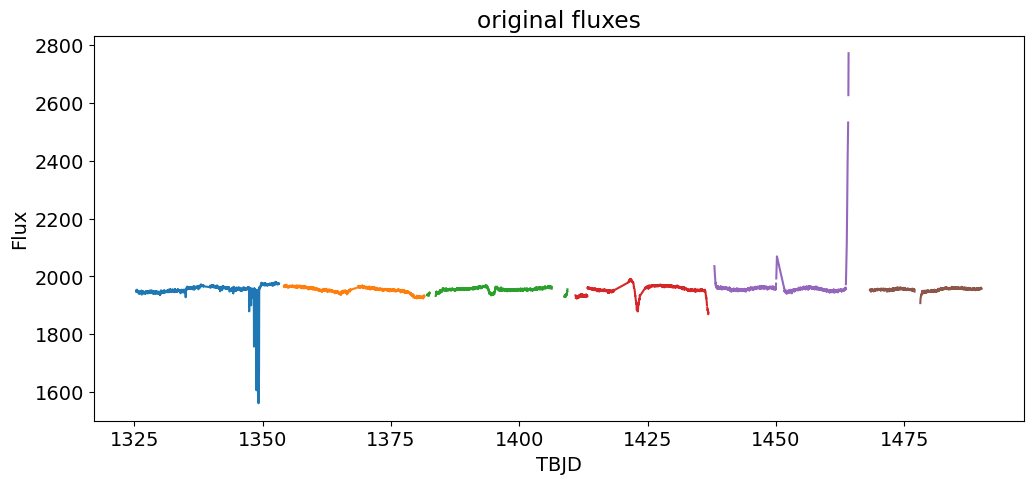

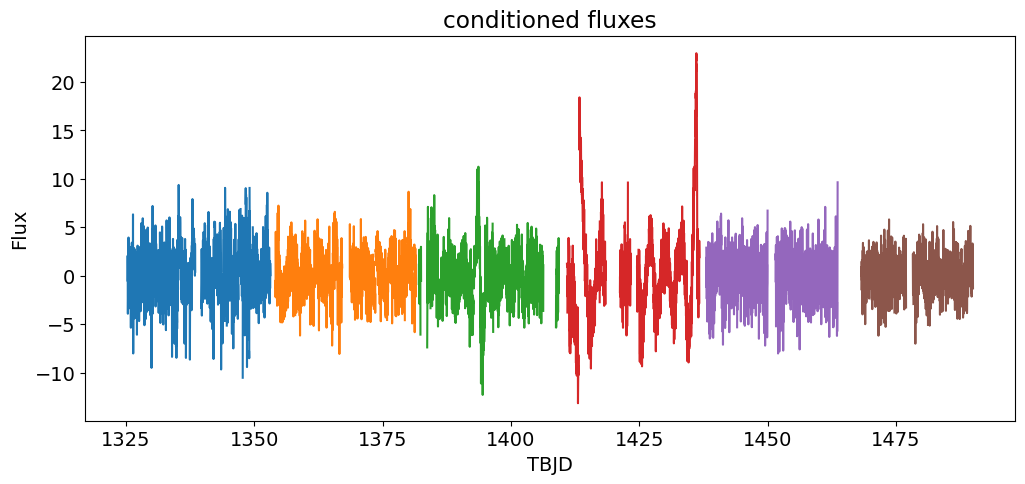

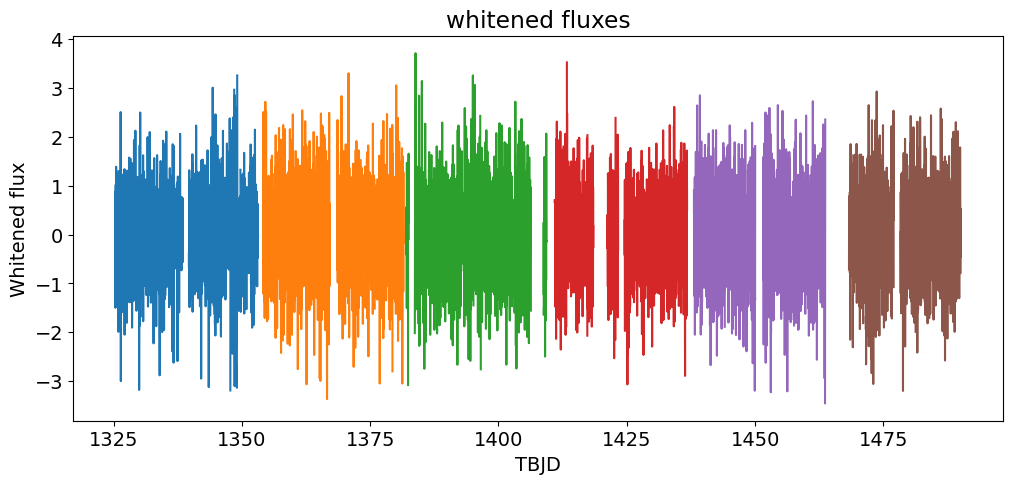

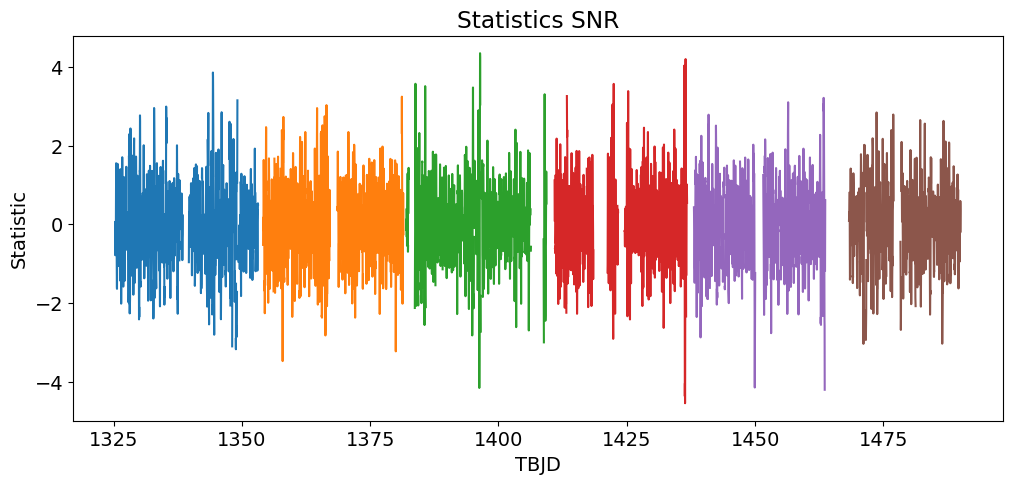

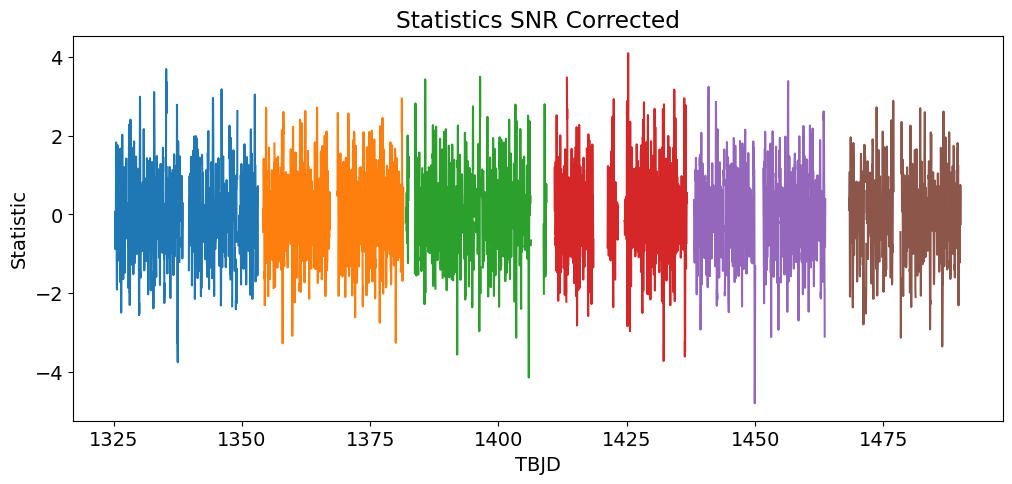

In [150]:
plt.figure(figsize=(12,5))
plot_sectors(times_plotting=tess_lc.times_orig, data_plotting=tess_lc.fluxes_orig, masks_plotting=tess_lc.masks_orig)
plt.xlabel('TBJD')
plt.ylabel('Flux')
plt.title('original fluxes')

###########################################################################################
plt.figure(figsize=(12,5))
plot_sectors(times_plotting=tess_lc.times, data_plotting=tess_lc.fluxes, masks_plotting=tess_lc.masks)
plt.xlabel('TBJD')
plt.ylabel('Flux')
plt.title('conditioned fluxes')

###########################################################################################
plt.figure(figsize=(12,5))
plot_sectors(times_plotting=tess_lc.times, 
             data_plotting=[tess_lc.whitened_fluxes_td[s][tess_lc.zero_padding_ends[s][0] : -tess_lc.zero_padding_ends[s][1]] 
                            for s in range(len(tess_lc.fluxes))], 
             masks_plotting=tess_lc.masks)
plt.xlabel('TBJD')
plt.ylabel('Whitened flux')
plt.title('whitened fluxes')

###########################################################################################
plt.figure(figsize=(12,5))
plot_sectors(times_plotting=tess_lc.times, 
             data_plotting=tess_lc.statistics_snr, 
             masks_plotting=tess_lc.masks)
plt.xlabel('TBJD')
plt.ylabel('Statistic')
plt.title('Statistics SNR')

###########################################################################################
plt.figure(figsize=(12,5))
plot_sectors(times_plotting=tess_lc.times, 
             data_plotting=tess_lc.statistics_snr_cor, 
             masks_plotting=tess_lc.masks)
plt.xlabel('TBJD')
plt.ylabel('Statistic')
plt.title('Statistics SNR Corrected')

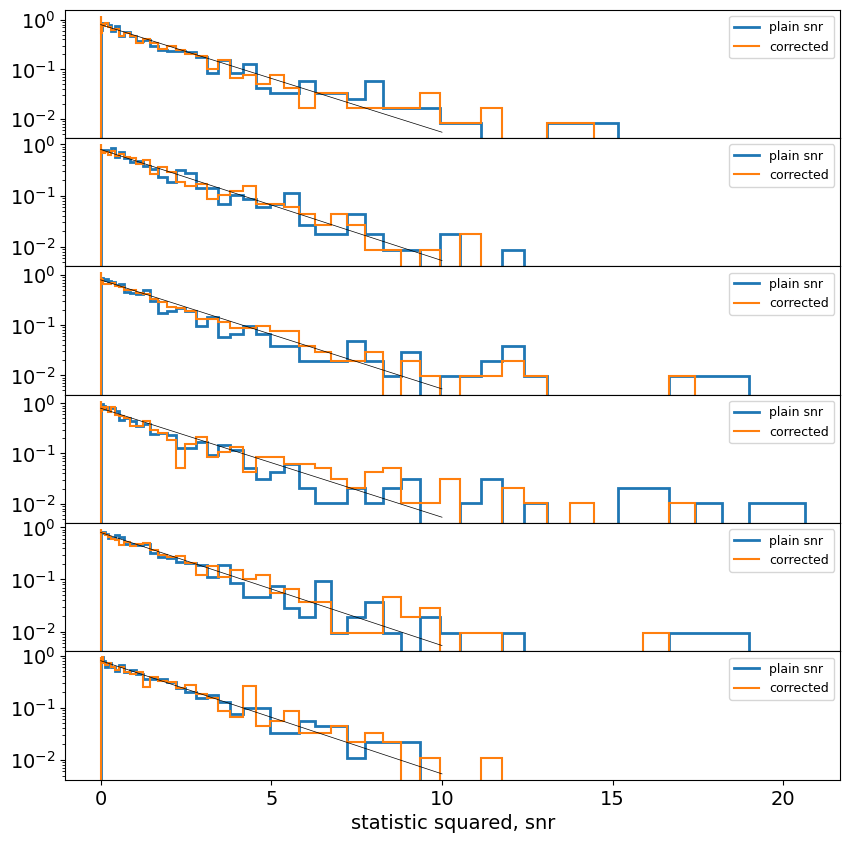

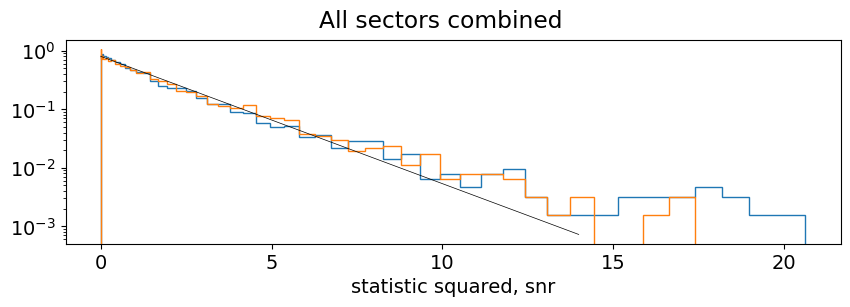

In [151]:
# fn 5%
maxbin = np.max([np.max(np.abs(tess_lc.statistics_snr[s][tess_lc.big_hole_masks[s]])) for s in range(len(tess_lc.statistics_snr))])
bins = np.linspace(0, maxbin, 50)

fig, axs = plt.subplots(len(tess_lc.statistics_snr),1, figsize=(10,10))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.0)
for s in range(len(tess_lc.statistics_snr)):
    c, b = np.histogram(np.abs(tess_lc.statistics_snr[s][tess_lc.big_hole_masks[s]]), bins=bins, density=True)
    axs[s].stairs(c, b**2, color=def_cols[0], linewidth=2, linestyle='-', label='plain snr' )
    c, b = np.histogram(np.abs(tess_lc.statistics_snr_cor[s][tess_lc.big_hole_masks[s]]), bins=bins, density=True)
    axs[s].stairs(c, b**2, color=def_cols[1], linewidth=1.5, linestyle='-', label='corrected')
    axs[s].set_yscale('log')
    if s < len(tess_lc.statistics_snr) - 1:
        axs[s].set_xticks([])

    xx = np.linspace(0,10,100)
    axs[s].plot(xx, np.exp(-xx/2) / (2 * np.pi)**0.5 * 2, color='k', linewidth=0.5)
    axs[s].legend(fontsize=9)
axs[-1].set_xlabel('statistic squared, snr')

# ###########################################################################################
stats_full = np.concatenate([(tess_lc.statistics_snr[s][tess_lc.big_hole_masks[s]]) for s in range(len(tess_lc.statistics_snr))])
stats_full_cor = np.concatenate([(tess_lc.statistics_snr_cor[s][tess_lc.big_hole_masks[s]]) for s in range(len(tess_lc.statistics_snr))])
fig, axs = plt.subplots(1,1, figsize=(10,3))

c, b = np.histogram(np.abs(stats_full), bins=bins, density=True)
axs.stairs(c, b**2, color=def_cols[0], linestyle='-', label='')

c, b = np.histogram(np.abs(stats_full_cor), bins=bins, density=True)
axs.stairs(c, b**2, color=def_cols[1], linestyle='-', label='')

axs.set_yscale('log')
xx = np.linspace(0,14,100)
axs.plot(xx, np.exp(-xx/2) / (2 * np.pi)**0.5 * 2, color='k', linewidth=0.5)
axs.set_xlabel('statistic squared, snr')
fig.suptitle('All sectors combined')
fig.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=None, hspace=None)

# Expected snr

In [152]:
# estimating the expected snr
tr_depth = 0.005
snrs_single = []
for s in range(len(tess_lc.wf_fds)):
    wf_fd = np.array(tess_lc.wf_fds[s])
    len_time = 2 * (len(wf_fd) - 1)
    template_normax = np.abs(tess_lc.template)
    template_normax = template_normax / np.max(template_normax)
    template_normax_white_norm = (np.sum(np.fft.irfft(np.fft.rfft(template_normax) * wf_fd)**2) )**0.5
    flux = tess_lc.means[s]
    snr_single = tr_depth * (flux * template_normax_white_norm)
    snrs_single.append(snr_single)
snrs_single = np.array(snrs_single)
print('for relative depth', tr_depth)
print('snr single transit:', np.round(np.mean(snrs_single),2), '+-', np.round(np.std(snrs_single),2))

for relative depth 0.005
snr single transit: 6.68 +- 1.55


Text(0.5, 1.0, 'Correlated noise is not super important because there us a scale separation here')

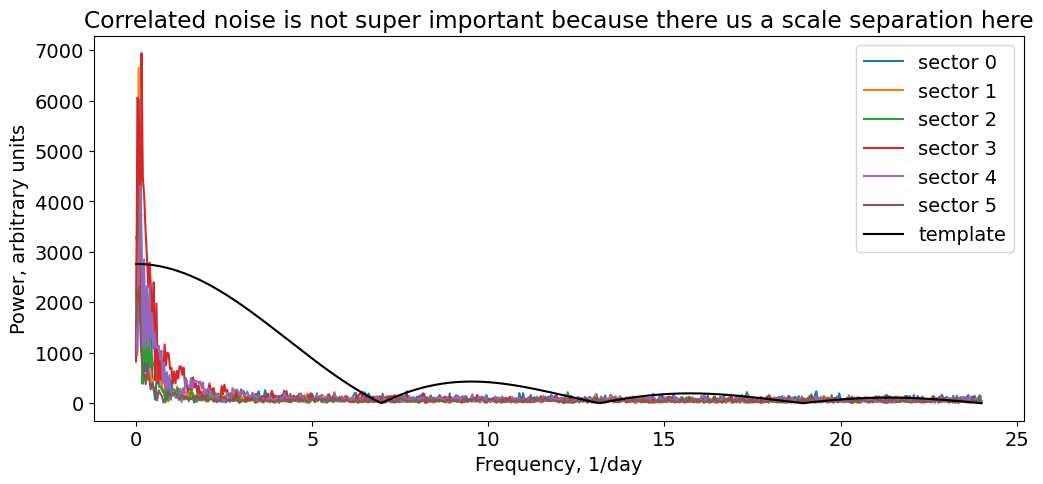

In [154]:

plt.figure(figsize=(12,5))
for s in range(len(tess_lc.fluxes)):
    plt.plot(np.fft.rfftfreq(len(tess_lc.fluxes_non_detrended[s]), d=tess_lc.dt), 
             np.abs(np.fft.rfft(tess_lc.fluxes_non_detrended[s])), label='sector '+str(s))
plt.plot(np.fft.rfftfreq(len(tess_lc.template), d=tess_lc.dt), np.abs(np.fft.rfft(tess_lc.template))*1000, color='k',
        label='template')

# plt.yscale('log')
plt.xlabel('Frequency, 1/day')
plt.ylabel('Power, arbitrary units')
plt.legend()
plt.title('Correlated noise is not super important because there us a scale separation here')

Snrs for prepared and detrended flux, but without red noise statistic:

In [153]:
rel_depth = 0.005
snrs_single = []
for s in range(len(tess_lc.fluxes)):
    snrs_single.append((tess_lc.means[s] * rel_depth) / np.std(tess_lc.fluxes[s][tess_lc.masks[s]]) 
                                                                      * np.linalg.norm(tess_lc.template/np.max(tess_lc.template)))

print('for relative depth', tr_depth)
print('snr naive single transit:', np.round(np.mean(snrs_single),2), '+-', np.round(np.std(snrs_single),2))



for relative depth 0.005
snr naive single transit: 8.86 +- 2.27


# Injection

We try to inject to every sector a trial signal of some depth, say 0.5% and see what happens. We see it gets detects peaks coinciding with black lines which are expected event times.

In [189]:
template = templates_trial[1]
nsig_outliers=5
detrending_length=64
psd_window=32
max_hole=3
phase_inj_days = 5
relative_depth_injection = 0.005

tessid = '150274888' # this is an example
data_dir = os.path.abspath('.')
tess_lc_inj = TESSLightCurve(tess_id=tessid, data_dir=data_dir)
tess_lc_inj.fill_exposures()
tess_lc_inj.make_injection(depth_rel=relative_depth_injection, phase_days=phase_inj_days, template=template)

tess_lc_inj.mask_outliers(n_sigma=nsig_outliers)
tess_lc_inj.clean_masks(max_hole=max_hole)
tess_lc_inj.deternd_low_freq(det_len=detrending_length)
tess_lc_inj.measure_psd(nperseg=psd_window)
tess_lc_inj.pad_with_zeros()
tess_lc_inj.whiten_fluxes()
tess_lc_inj.whiten_template(template=template)
tess_lc_inj.matched_filtering()

phase_inj_bins = int(phase_inj_days/tess_lc_inj.dt)

/Users/orynaivashtenko/micromamba/envs/planets_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/orynaivashtenko/Work/TESS/tess_utils.py:711: RuntimeWarning: divide by zero encountered in scalar divide
  mov_var.append(((sum2[i + hnw] - sum2[i + hng] + sum2[i - hng] - sum2[i - hnw]) / counts
/Users/orynaivashtenko/Work/TESS/tess_utils.py:711: RuntimeWarning: invalid value encountered in scalar divide
  mov_var.append(((sum2[i + hnw] - sum2[i + hng] + sum2[i - hng] - sum2[i - hnw]) / counts
/Users/orynaivashtenko/Work/TESS/tess_utils.py:712: RuntimeWarning: invalid value encountered in scalar divide
  - (((sum1[i + hnw] - sum1[i + hng] + sum1[i - hng] - sum1[i - hnw]) / counts) ** 2)) * counts / (counts - 1))


Text(0.5, 1.0, 'Statistics SNR Corrected')

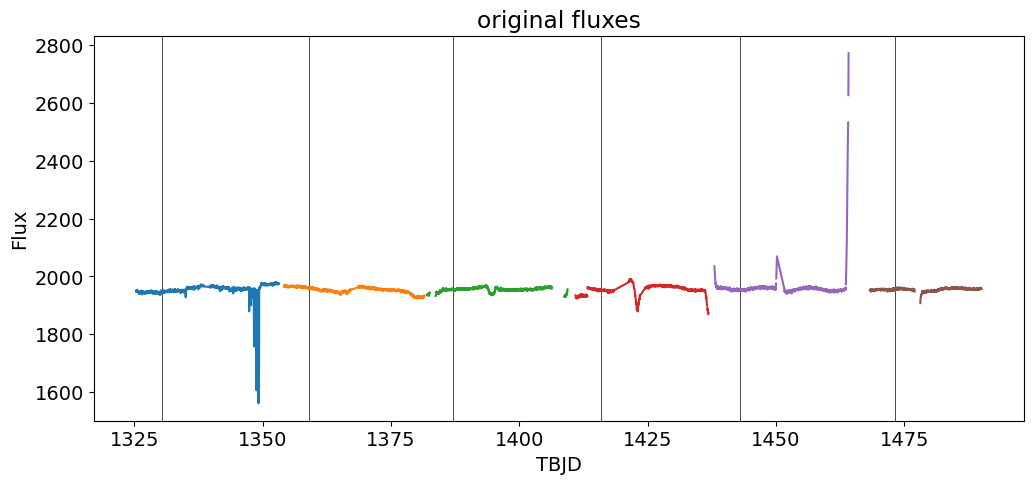

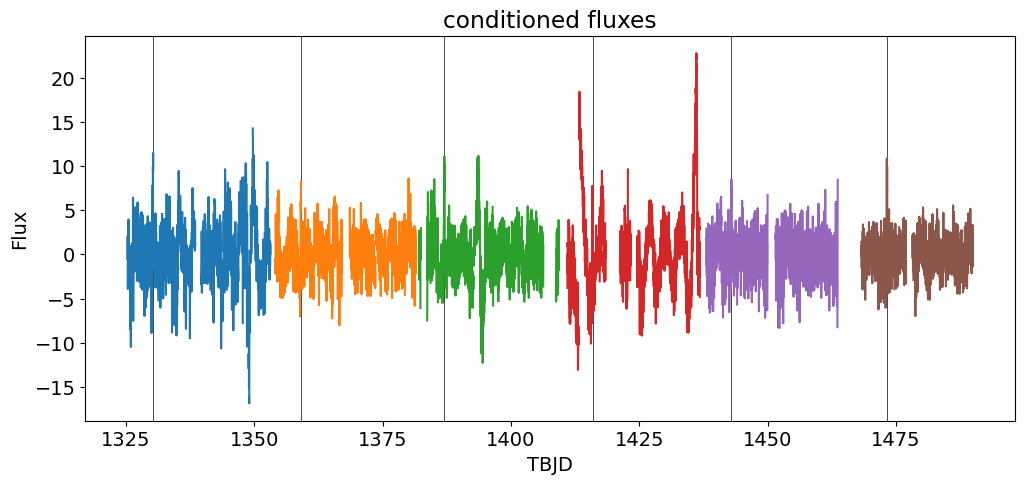

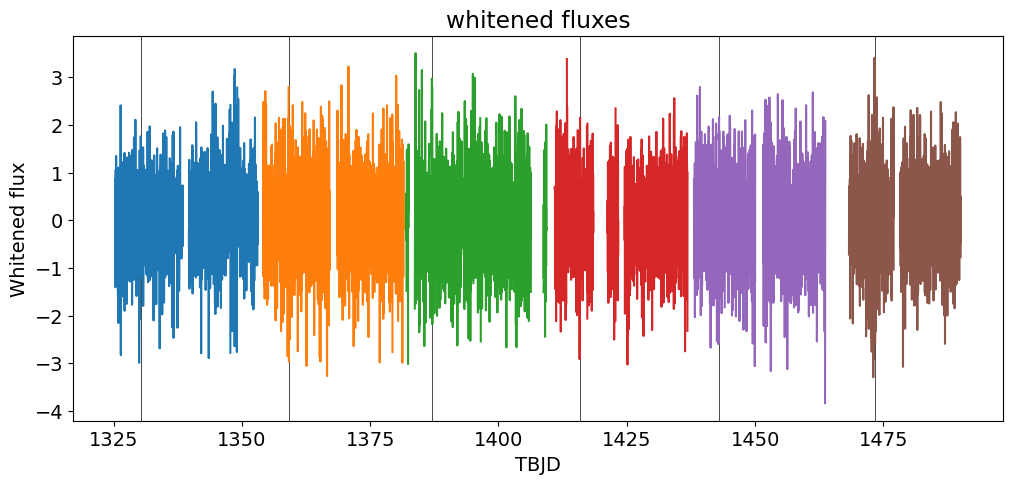

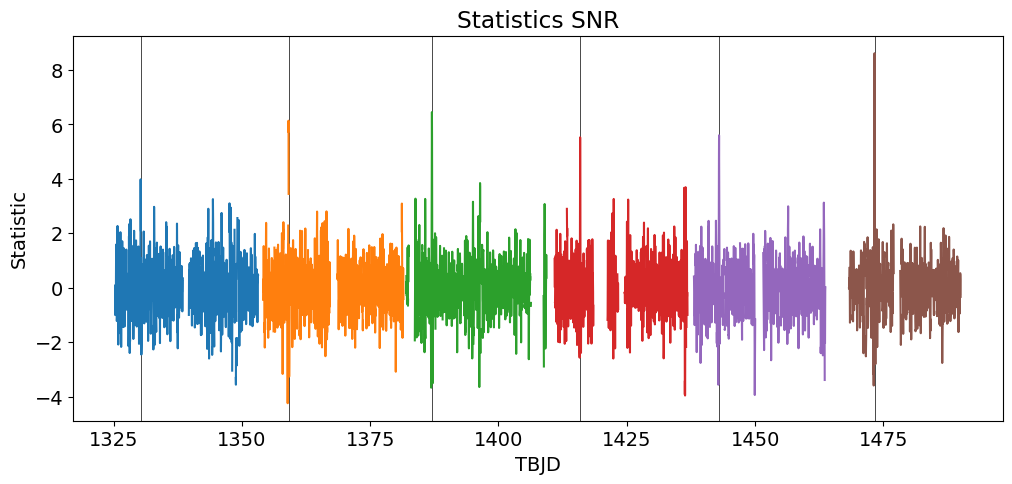

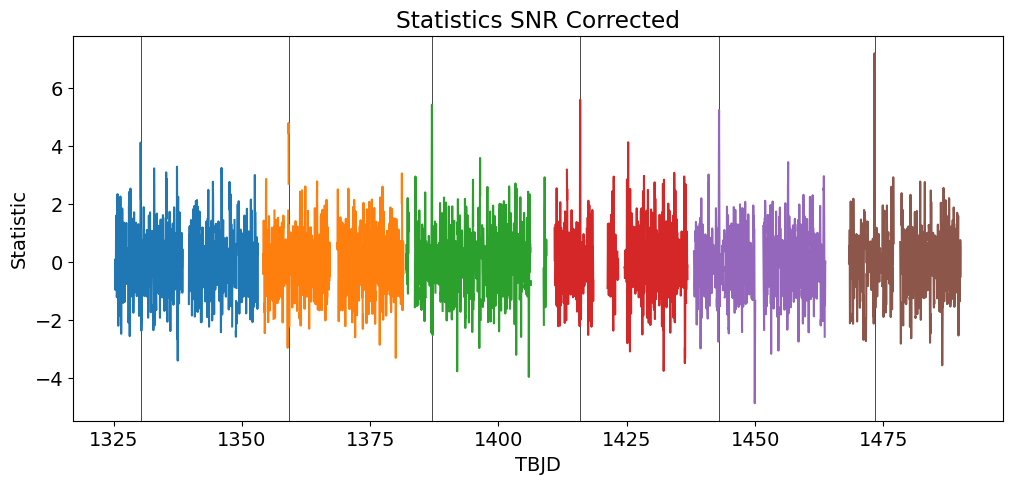

In [190]:
plt.figure(figsize=(12,5))
for s in range(len(tess_lc_inj.times)):
    plt.axvline(tess_lc_inj.times[s][phase_inj_bins], color='k', linewidth=0.5) 
plot_sectors(times_plotting=tess_lc_inj.times_orig, data_plotting=tess_lc_inj.fluxes_orig, masks_plotting=tess_lc_inj.masks_orig)
plt.xlabel('TBJD')
plt.ylabel('Flux')
plt.title('original fluxes')

###########################################################################################
plt.figure(figsize=(12,5))
for s in range(len(tess_lc_inj.times)):
    plt.axvline(tess_lc_inj.times[s][phase_inj_bins], color='k', linewidth=0.5)
plot_sectors(times_plotting=tess_lc_inj.times, data_plotting=tess_lc_inj.fluxes, masks_plotting=tess_lc_inj.masks)
plt.xlabel('TBJD')
plt.ylabel('Flux')
plt.title('conditioned fluxes')

###########################################################################################
plt.figure(figsize=(12,5))
for s in range(len(tess_lc_inj.times)):
    plt.axvline(tess_lc_inj.times[s][phase_inj_bins], color='k', linewidth=0.5)
plot_sectors(times_plotting=tess_lc_inj.times, 
             data_plotting=[tess_lc_inj.whitened_fluxes_td[s][tess_lc_inj.zero_padding_ends[s][0] : -tess_lc_inj.zero_padding_ends[s][1]] 
                            for s in range(len(tess_lc_inj.fluxes))], 
             masks_plotting=tess_lc_inj.masks)
plt.xlabel('TBJD')
plt.ylabel('Whitened flux')
plt.title('whitened fluxes')

###########################################################################################
plt.figure(figsize=(12,5))
for s in range(len(tess_lc_inj.times)):
    plt.axvline(tess_lc_inj.times[s][phase_inj_bins], color='k', linewidth=0.5)
plot_sectors(times_plotting=tess_lc_inj.times, 
             data_plotting=tess_lc_inj.statistics_snr, 
             masks_plotting=tess_lc_inj.masks)
plt.xlabel('TBJD')
plt.ylabel('Statistic')
plt.title('Statistics SNR')

###########################################################################################
plt.figure(figsize=(12,5))
for s in range(len(tess_lc_inj.times)):
    plt.axvline(tess_lc_inj.times[s][phase_inj_bins], color='k', linewidth=0.5)
plot_sectors(times_plotting=tess_lc_inj.times, 
             data_plotting=tess_lc_inj.statistics_snr_cor, 
             masks_plotting=tess_lc_inj.masks)
plt.xlabel('TBJD')
plt.ylabel('Statistic')
plt.title('Statistics SNR Corrected')